<a href="https://colab.research.google.com/github/shahchhatru/AI_colab_notebooks/blob/main/EngHuggTranslatorintf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import io
import io
import json
import numpy as np
import pandas as pd
import random 
import re
import tensorflow as tf
import unicodedata

from google.colab import files
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Downloading the training set

In [2]:
!wget https://raw.githubusercontent.com/nitinpunjabi/nlp-demystified/main/datasets/hun_eng_pairs/hun_eng_pairs_train.txt

--2023-05-16 07:02:23--  https://raw.githubusercontent.com/nitinpunjabi/nlp-demystified/main/datasets/hun_eng_pairs/hun_eng_pairs_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5518306 (5.3M) [text/plain]
Saving to: ‘hun_eng_pairs_train.txt’

hun_eng_pairs_train 100%[===================>]   5.26M  --.-KB/s    in 0.09s   

2023-05-16 07:02:23 (56.5 MB/s) - ‘hun_eng_pairs_train.txt’ saved [5518306/5518306]



### Loading the pairs into list

In [3]:
with open('hun_eng_pairs_train.txt') as file:
  train=[line.strip() for line in file]

In [4]:
train[:3]

["Teszek rá, mit mondasz!<sep>I don't care what you say.",
 'Több olyan ember kell nekünk a csapatba, mint amilyen te vagy.<sep>We need more people like you on our team.',
 'Vigyázz a gyerekeimre!<sep>Take care of my children.']

In [5]:
len(train)

88647

In [ ]:
# pretty small dataset but it's fine.

### Let's separate our input Hungarian and Output Engish into seperate List 

In [6]:
SEPERATOR = "<sep>"
train_input, train_target = map(list,zip(*[pair.split(SEPERATOR) for pair in train]))

In [7]:
train_input[:3]

['Teszek rá, mit mondasz!',
 'Több olyan ember kell nekünk a csapatba, mint amilyen te vagy.',
 'Vigyázz a gyerekeimre!']

In [8]:
train_target[:3]

["I don't care what you say.",
 'We need more people like you on our team.',
 'Take care of my children.']

Since we're dealing with a source language that uses accented characters, it's important to apply *Unicode normalization* 
<br><br>
In the example below, two different sets of Unicode yield the same character visually. The first Unicode is for an accented 'a', while the second Unicode combines an 'a' with an accent mark.

In [9]:
def unicode_normalize(s):
  return ''.join( c for c in unicodedata.normalize('NFD',s) if unicodedata.category(c) != 'Mn')

We are building word based translation model , but we still want to keep punctuation and treat them as seperate seperate tokens so we will insert a space between any relevant punctuation and characters around them . This way , our tokenizer (which won't filter out punctuation ) will output punctuation marks as seperate tokens.

Below function does that and unicode normalization

In [10]:
def preprocess_sentences(s):
  s=unicode_normalize(s)
  s = re.sub(r"([?.!,¿])", r" \1 ", s)
  s = re.sub(r'[" "]+', " ", s)
  s = s.strip()
  return s

In [11]:
train_preprocessed_input =[preprocess_sentences(s) for s in train_input]
train_preprocessed_target=[preprocess_sentences(s) for s in train_target]

In [12]:
train_preprocessed_input[:3]

['Teszek ra , mit mondasz !',
 'Tobb olyan ember kell nekunk a csapatba , mint amilyen te vagy .',
 'Vigyazz a gyerekeimre !']

In [13]:
train_preprocessed_target[:3]

["I don't care what you say .",
 'We need more people like you on our team .',
 'Take care of my children .']

In [14]:
def tag_target_sentences(sentences):
   tagged_sentences = map(lambda s: (' ').join(['<sos>', s, '<eos>']), sentences)
   return list(tagged_sentences)

In [15]:
train_tagged_preprocessed_target = tag_target_sentences(train_preprocessed_target)

In [16]:
train_tagged_preprocessed_target[:3]

["<sos> I don't care what you say . <eos>",
 '<sos> We need more people like you on our team . <eos>',
 '<sos> Take care of my children . <eos>']

In [17]:
source_tokenizer=tf.keras.preprocessing.text.Tokenizer(oov_token='<unk>', filters='"#$%&()*+-/:;=@[\\]^_`{|}~\t\n')
source_tokenizer.fit_on_texts(train_preprocessed_input)
source_tokenizer.get_config()

{'num_words': None,
 'filters': '"#$%&()*+-/:;=@[\\]^_`{|}~\t\n',
 'lower': True,
 'split': ' ',
 'char_level': False,
 'oov_token': '<unk>',
 'document_count': 88647,
 'word_counts': '{"teszek": 28, "ra": 440, ",": 18083, "mit": 1494, "mondasz": 37, "!": 5817, "tobb": 266, "olyan": 737, "ember": 282, "kell": 2251, "nekunk": 267, "a": 24987, "csapatba": 4, "mint": 988, "amilyen": 23, "te": 993, "vagy": 1642, ".": 68274, "vigyazz": 39, "gyerekeimre": 3, "miert": 1668, "van": 5268, "szuksege": 134, "onoknek": 27, "ket": 443, "kerekparra": 25, "?": 15270, "nincs": 1243, "helye": 4, "ketsegnek": 2, "mary": 560, "benyult": 7, "az": 8383, "erszenyebe": 1, "es": 1543, "elovett": 6, "egy": 5808, "fenykepet": 12, "sok": 683, "butor": 8, "volt": 3040, "szobaban": 72, "tarstalan": 1, "vagyok": 2076, "en": 1352, "is": 1103, "remelem": 296, "mikor": 700, "ert": 85, "veget": 44, "ezt": 2294, "bicot": 24, "meg": 4966, "vetted": 101, "lathatom": 7, "tom": 10857, "kuzdott": 5, "adnal": 4, "nekem": 1418

In [40]:
source_vocab_size=len(source_tokenizer.word_index)+1

In [19]:
# Tokenizer for the English target sentences.
target_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<unk>', filters='"#$%&()*+-/:;=@[\\]^_`{|}~\t\n')
target_tokenizer.fit_on_texts(train_tagged_preprocessed_target)
target_tokenizer.get_config()

{'num_words': None,
 'filters': '"#$%&()*+-/:;=@[\\]^_`{|}~\t\n',
 'lower': True,
 'split': ' ',
 'char_level': False,
 'oov_token': '<unk>',
 'document_count': 88647,
 'word_counts': '{"<sos>": 88647, "i": 19473, "don\'t": 4041, "care": 217, "what": 3414, "you": 16070, "say": 507, ".": 73314, "<eos>": 88647, "we": 3700, "need": 1407, "more": 671, "people": 531, "like": 2543, "on": 2426, "our": 550, "team": 66, "take": 799, "of": 4600, "my": 3969, "children": 325, "why": 1767, "do": 5407, "two": 526, "bicycles": 121, "?": 15204, "there\'s": 497, "no": 1269, "room": 426, "for": 3071, "doubt": 53, "mary": 1767, "reached": 43, "into": 351, "her": 868, "purse": 17, "and": 1734, "took": 331, "out": 1073, "a": 11379, "photo": 14, "there": 1550, "was": 4470, "lot": 561, "furniture": 19, "in": 4576, "the": 14579, "i\'m": 3674, "lonely": 25, "hope": 392, "so": 907, ",": 3644, "too": 786, "when": 1061, "did": 2141, "it": 5384, "end": 89, "buy": 625, "this": 4898, "bicycle": 672, "can": 2263, "se

In [20]:
target_vocab_size = len(target_tokenizer.word_index) + 1
print(target_vocab_size)

10556


In [21]:
#let's encode our sentences
train_encoder_inputs= source_tokenizer.texts_to_sequences(train_preprocessed_input)

In [22]:
type(train_encoder_inputs)

list

In [23]:
len(train_encoder_inputs),len(train_encoder_inputs[0])

(88647, 6)

In [24]:
len(train_encoder_inputs),len(train_encoder_inputs[2])

(88647, 4)

In [25]:
train_encoder_inputs[:3]

[[1395, 91, 4, 27, 1080, 10],
 [153, 56, 145, 17, 152, 3, 7232, 4, 45, 1670, 44, 23, 2],
 [1026, 3, 8933, 10]]

In [26]:
def generate_decoder_inputs_targets(sentences, tokenizer):
  seqs = tokenizer.texts_to_sequences(sentences)
  decoder_inputs = [s[:-1] for s in seqs] # Drop the last token in the sentence.
  decoder_targets = [s[1:] for s in seqs] # Drop the first token in the sentence.

  return decoder_inputs, decoder_targets

In [27]:
train_decoder_inputs, train_decoder_targets = generate_decoder_inputs_targets(train_tagged_preprocessed_target, 
                                                                              target_tokenizer)

In [28]:
print(train_decoder_inputs[0], train_decoder_targets[0])

print(target_tokenizer.sequences_to_texts(train_decoder_inputs[:1]), 
      target_tokenizer.sequences_to_texts(train_decoder_targets[:1]))

[2, 5, 23, 306, 28, 7, 151, 4] [5, 23, 306, 28, 7, 151, 4, 3]
["<sos> i don't care what you say ."] ["i don't care what you say . <eos>"]


In [29]:
#let's padd our sequences.
max_encoding_len=len(max(train_encoder_inputs,key=len))
print(max_encoding_len)

37


In [30]:
max_decoding_len=len(max(train_decoder_inputs,key=len))

In [31]:
# we padding so that we can have two dimensional array of same size.
padded_train_encoder_inputs = pad_sequences(train_encoder_inputs, max_encoding_len, padding='post', truncating='post')
padded_train_decoder_inputs = pad_sequences(train_decoder_inputs, max_decoding_len, padding='post', truncating='post')
padded_train_decoder_targets = pad_sequences(train_decoder_targets, max_decoding_len, padding='post', truncating='post')

In [32]:
np.array(padded_train_decoder_inputs).shape

(88647, 34)

In [33]:
target_tokenizer.sequences_to_texts([padded_train_decoder_inputs[0]])

["<sos> i don't care what you say . <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>"]

## Preprocessing for validation set

In [34]:
# Download validation set pairs.
!wget https://raw.githubusercontent.com/nitinpunjabi/nlp-demystified/main/datasets/hun_eng_pairs/hun_eng_pairs_val.txt

--2023-05-16 07:04:29--  https://raw.githubusercontent.com/nitinpunjabi/nlp-demystified/main/datasets/hun_eng_pairs/hun_eng_pairs_val.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 646226 (631K) [text/plain]
Saving to: ‘hun_eng_pairs_val.txt’

hun_eng_pairs_val.t 100%[===================>] 631.08K  --.-KB/s    in 0.05s   

2023-05-16 07:04:29 (11.3 MB/s) - ‘hun_eng_pairs_val.txt’ saved [646226/646226]



In [35]:
with open('hun_eng_pairs_val.txt') as file:
  val = [line.rstrip() for line in file]

In [36]:
print(SEPERATOR)

<sep>


In [37]:
def process_dataset(dataset):

  # Split the Hungarian and English sentences into separate lists.
  input, output = map(list, zip(*[pair.split(SEPERATOR) for pair in dataset]))

  # Unicode normalization and inserting spaces around punctuation.
  preprocessed_input = [preprocess_sentences(s) for s in input]
  preprocessed_output = [preprocess_sentences(s) for s in output]

  # Tag target sentences with <sos> and <eos> tokens.
  tagged_preprocessed_output = tag_target_sentences(preprocessed_output)

  # Vectorize encoder source sentences.
  encoder_inputs = source_tokenizer.texts_to_sequences(preprocessed_input)

  # Vectorize and create decoder input and target sentences.
  decoder_inputs, decoder_targets = generate_decoder_inputs_targets(tagged_preprocessed_output, 
                                                                    target_tokenizer)
  
  # Pad all collections.
  padded_encoder_inputs = pad_sequences(encoder_inputs, max_encoding_len, padding='post', truncating='post')
  padded_decoder_inputs = pad_sequences(decoder_inputs, max_decoding_len, padding='post', truncating='post')
  padded_decoder_targets = pad_sequences(decoder_targets, max_decoding_len, padding='post', truncating='post')

  return padded_encoder_inputs, padded_decoder_inputs, padded_decoder_targets


In [38]:
# Process validation dataset
padded_val_encoder_inputs, padded_val_decoder_inputs, padded_val_decoder_targets = process_dataset(val)

We are ready to build our translation model.


In [39]:
embedding_dim = 128
hidden_dim = 256
default_dropout=0.2
batch_size = 32
epochs = 30

Unlike the models we've built up to this point, this model will have **two** inputs:<br>
1. The encoder receives the source sentences (Hungarian) and generates the initial state inputs for the decoder.
2. The decoder receives the decoder input sentences (English) for teacher forcing.
<br>

Since that's the case, we won't use the Keras **Sequential API**. Rather, we'll use the **Functional API** which will give us more flexibility in expressing our model layers as graphs. Fortunately, the work remains pretty intuitive as long as we keep in mind what's happening behind the scenes.
<br>

https://keras.io/api/models/sequential/<br>
https://www.tensorflow.org/guide/keras/functional/

The code in the following cell specifies the encoder. If you haven't used the **Functional API** before, the most important thing to realize here is this: Each layer is like a _node_ in a graph. Each time we pass the output of one layer to the next, it creates a link between the two _nodes_ and allows data to flow through. Once the whole training model is built, we'll visualize it for greater clarity.

In [42]:
#the initial encoder input layer will take in the padded sequences . We are specifying 
#a space of None , Here but you can specify it upfront if you want since we know what the max length is
#
encoder_inputs = layers.Input(shape=[None], name="encoder_inputs")
encoder_embeddings = layers.Embedding(source_vocab_size,embedding_dim,mask_zero=True,name="encoder_embeddings")

encoder_embedding_output = encoder_embeddings(encoder_inputs)

encoder_lstm=layers.LSTM(hidden_dim, return_state=True,dropout=default_dropout,name='encoder_lstm')
# Passing the embedding layer output to the LSTM layer creates another link.
# IMPORTANT: The LSTM always returns three values. When return_sequences is
# False, encoder_outputs and state_h are the SAME. When return_sequences is
# True, encoder_outputs contains the encoder hidden states from each time step.
#
# Side note: we won't be using encoder_outputs here so that variable can be 
# replaced with a _ if preferred.

encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding_output)


# The final hidden and cell/context states from the encoder will be the the
# initial states for the decoder.
encoder_states = (state_h, state_c)


The code for specifying the decoder is similar except for three additions:
1. The LSTM has *return_sequences* set to *True* since we'll need the hidden state outputted at each timestep (similar to our PoS tagger and language model from the [RNN demo](https://github.com/nitinpunjabi/nlp-demystified/blob/main/notebooks/nlpdemystified_recurrent_neural_networks.ipynb)).

2. The decoder's LSTM takes an *initial_state*, the value for which is from the encoder.

3. There's a *softmax* layer in the end to generate a probability distribution over the target (English) vocabulary.

In [45]:
decoder_inputs=layers.Input(shape=[None],name="decoder_inputs")
decoder_embeddings=layers.Embedding(target_vocab_size,embedding_dim,mask_zero=True,name='decoder_embeddings')
decoder_embedding_output = decoder_embeddings(decoder_inputs)

decoder_lstm = layers.LSTM(hidden_dim,
                           return_sequences=True,
                           return_state=True,
                           dropout=default_dropout,
                           name='decoder_lstm')

# Set the decoder's initial state to the encoder's final output states. Since
# return_sequences is set to True, decoder_outputs is going to be a collection of
# the decoder's hidden state at each timestep. Also note that since we don't need
# the decoder's final hidden output and cell states, those are just set to _.
decoder_outputs, _, _ = decoder_lstm(decoder_embedding_output, initial_state=encoder_states)

# Have a softmax layer in the end to create a probability distribution for the output word.
decoder_dense = layers.Dense(target_vocab_size, activation='softmax', name='decoder_dense')

# The probability distribution for the output word.
y_proba = decoder_dense(decoder_outputs)


We can now create our model and specify that it has **two** inputs and one output.
<br><br>
Note that *accuracy* is a crude metric for translation models and just serves as a proxy for how our model is doing. As we covered in the slides, the popular performance metric is BLEU.

In [46]:
# Note how the model is taking two inputs in an array.
model = tf.keras.Model([encoder_inputs, decoder_inputs], y_proba, name='hun_eng_seq2seq_nmt_no_attention')

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',  metrics='sparse_categorical_accuracy')
model.summary()

Model: "hun_eng_seq2seq_nmt_no_attention"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 encoder_embeddings (Embedding)  (None, None, 128)   4932992     ['encoder_inputs[0][0]']         
                                                                                                  
 decoder_embeddings (Embedding)  (None, None, 128)   1351168     ['decoder_inputs[0][0]']         
                                                                   

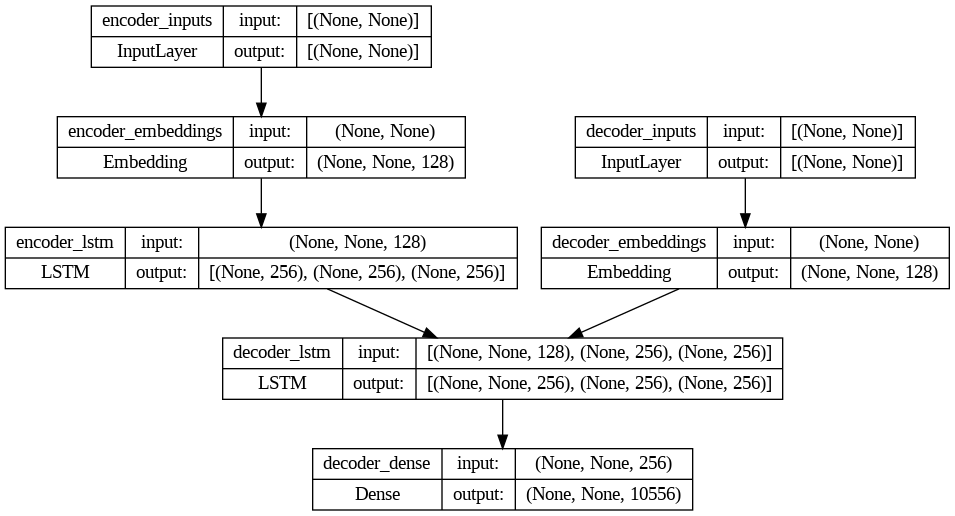

In [47]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='hun_eng_seq2seq_nmt_no_attention.png', show_shapes=True, show_layer_names=True)

In [48]:
print('encoder_inputs layer\n input dimension {}\n output dimension: {}'.format((batch_size, max_encoding_len), (batch_size, max_encoding_len)))
print()
print('encoder_embeddings layer\n input dimension {}\n output dimension: {}'.format((batch_size, max_encoding_len), (batch_size, max_encoding_len, embedding_dim)))
print()
print('encoder_lstm layer\n input dimension {}\n output dimension: {}'.format((batch_size, max_encoding_len, embedding_dim), [(batch_size, hidden_dim), (batch_size, hidden_dim), (batch_size, hidden_dim)]))
print()
print()
print('decoder_inputs layer\n input dimension {}\n output dimension: {}'.format((batch_size, max_decoding_len), (batch_size, max_decoding_len)))
print()
print('decoder_embeddings layer\n input dimension {}\n output dimension: {}'.format((batch_size, max_decoding_len), (batch_size, max_decoding_len, embedding_dim)))
print()
print('decoder_lstm layer\n input dimension {}\n output dimension: {}'.format([(batch_size, max_decoding_len, embedding_dim), (batch_size, hidden_dim), (batch_size, hidden_dim)], [(batch_size, max_decoding_len, hidden_dim), (batch_size, hidden_dim), (batch_size, hidden_dim)]))
print()
print('decoder_dense layer(softmax)\n input dimension {}\n output dimension: {}'.format((batch_size, max_decoding_len, hidden_dim), (batch_size, max_decoding_len, target_vocab_size)))

encoder_inputs layer
 input dimension (32, 37)
 output dimension: (32, 37)

encoder_embeddings layer
 input dimension (32, 37)
 output dimension: (32, 37, 128)

encoder_lstm layer
 input dimension (32, 37, 128)
 output dimension: [(32, 256), (32, 256), (32, 256)]


decoder_inputs layer
 input dimension (32, 34)
 output dimension: (32, 34)

decoder_embeddings layer
 input dimension (32, 34)
 output dimension: (32, 34, 128)

decoder_lstm layer
 input dimension [(32, 34, 128), (32, 256), (32, 256)]
 output dimension: [(32, 34, 256), (32, 256), (32, 256)]

decoder_dense layer(softmax)
 input dimension (32, 34, 256)
 output dimension: (32, 34, 10556)




```
# This is formatted as code
```

Because this model takes a while to train, we're using model checkpoints to save the weights after every epoch. This way, if something goes wrong with our system during training, we can reload the last set of weights from the checkpoint, and resume training from there.
https://keras.io/api/callbacks/model_checkpoint/

In [50]:
# Saving this to a folder on my local machine.
filepath="./HunEngNMTNoAttention/training1/cp.ckpt"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                 save_weights_only=True,
                                                 verbose=1)

In [49]:
# a call back that early stops.
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit([padded_train_encoder_inputs, padded_train_decoder_inputs], padded_train_decoder_targets,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_data=([padded_val_encoder_inputs, padded_val_decoder_inputs], padded_val_decoder_targets),
                   callbacks=[cp_callback, es_callback])

NameError: ignored

The model I previously trained exited at epoch 12 with these metrics.

> Epoch 12: saving model to ./HunEngNMTNoAttention/training1/cp.ckpt
2771/2771 [==============================] - 105s 38ms/step 
- loss: 0.1315 - sparse_categorical_accuracy: 0.8450 
- val_loss: 0.3996 - val_sparse_categorical_accuracy: 0.6832

